In [1]:
import os
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import numpy as np
import pandas as pd
import xgboost as xgb
import transformers
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from transformers import pipeline, AutoTokenizer, AutoModel, AutoModelForSequenceClassification
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedGroupKFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from matplotlib import pyplot as plt

In [2]:
## check mac gpu availability
print(f"MPS available: {torch.backends.mps.is_available()}")
print(f"MPS activated?: {torch.backends.mps.is_built()}")
#device = torch.device("mps") 
## Apple Metal Performance Shaders(MPS) backend: maps torch ML computational graphs & primitives onto the MPS graph framework
DEVICE = torch.device("mps")
TRAIN_DATA_DIR = "./corpus_df.csv" # processed data
TEST_DATA_DIR = "./data/Test.csv"
FOLDS = 5

MPS available: True
MPS activated?: True


In [3]:
x = torch.Tensor([[12, 3, 4, 12], [46, 55, 17, 29]])
y = torch.Tensor([[12, 3, 4, 12], [4, 5, 7, 9]])
print(x.shape, y.shape)
#x @ y.T

torch.Size([2, 4]) torch.Size([2, 4])


In [4]:
c = x.unsqueeze(-1).expand(y.unsqueeze(-1).size())#.shape
print(c, c.shape, y.shape)
torch.sum(y.unsqueeze(-1) * c, 1) / torch.clamp(c.sum(1), min=1e-9) # row-wise sum(element_wise mul(y, c)) / bounded(row-wise_sum(c), min=<>, max=none)

tensor([[[12.],
         [ 3.],
         [ 4.],
         [12.]],

        [[46.],
         [55.],
         [17.],
         [29.]]]) torch.Size([2, 4, 1]) torch.Size([2, 4])


tensor([[10.0968],
        [ 5.7075]])

In [5]:
# https://huggingface.co/masakhane/afroxlmr-large-ner-masakhaner-1.0_2.0
# https://huggingface.co/Davlan/afro-xlmr-mini
# https://huggingface.co/microsoft/mdeberta-v3-base
afroxlm_tokenizer = AutoTokenizer.from_pretrained("./afroxlmr-large-ner-masakhaner-1.0_2.0")
afroxlm_model = AutoModel.from_pretrained("./afroxlmr-large-ner-masakhaner-1.0_2.0")

mdeberta_tokenizer = AutoTokenizer.from_pretrained("./mdeberta-v3-base")
mdeberta_model = AutoModel.from_pretrained("./mdeberta-v3-base")

Some weights of XLMRobertaModel were not initialized from the model checkpoint at ./afroxlmr-large-ner-masakhaner-1.0_2.0 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/Users/smugisha/Downloads/POS_tagging/env/lib/python3.11/site-packages/transformers/convert_slow_tokenizer.py:470: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added i

In [6]:
# Load data
data_df = pd.read_csv(TRAIN_DATA_DIR)
test_df = pd.read_csv(TEST_DATA_DIR)
all_data = pd.concat([data_df[["Word", "Language", "Pos"]], test_df[["Word", "Language", "Pos"]]], axis=0)
groups = data_df["Language"].values
corpus = data_df["Word"].values
labels = data_df["Pos"].values
skfold = StratifiedGroupKFold(n_splits=FOLDS, shuffle=True, random_state=42)
for i, (train_idx, val_idx) in enumerate(skfold.split(corpus, labels, groups)):
	data_df.loc[val_idx, "fold"] = i

print(data_df["fold"].value_counts())
data_df.head()

fold
0.0    24952
2.0    24599
1.0    17127
3.0    15639
4.0    15513
Name: count, dtype: int64


,Word,Pos,Language,split,fold
0,chetekwa,VERB,ibo,dev,0.0
1,ịma,VERB,ibo,dev,0.0
2,adịrịrị,VERB,ibo,dev,0.0
3,ụkwa,NOUN,ibo,dev,0.0
4,jighị,VERB,ibo,dev,0.0


In [7]:
## Add unknown/new words to vocabulary in case they don't exist
def add_tokens_to_vocab(model, tokenizer, corpus):
	vocabulary = set(tokenizer.get_vocab().keys())
	for word in corpus:
		if word not in vocabulary:
			tokenizer.add_tokens(word)

	model.resize_token_embeddings(len(tokenizer))

add_tokens_to_vocab(afroxlm_model, afroxlm_tokenizer, data_df)
add_tokens_to_vocab(mdeberta_model, mdeberta_tokenizer, data_df)

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embeding dimension will be 250005. This might induce some performance reduction as *Tensor Cores* will not be available. For more details  about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embeding dimension will be 250102. This might induce some performance reduction as *Tensor Cores* will not be available. For more details  about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


In [8]:
# Model config
MAX_LEN = 512 #128
BATCH_SIZE = 4

In [9]:
#help(afroxlm_tokenizer)
tokens = afroxlm_tokenizer(
	text=list(data_df["Word"][:10]),
	padding="max_length",
	truncation=True,
	max_length=MAX_LEN,
	return_tensors="pt"
)
tokens = {k:v.squeeze(0) for k, v in tokens.items()}
tokens

{'input_ids': tensor([[    0,   290,    67,  ...,     1,     1,     1],
         [    0,     6, 51721,  ...,     1,     1,     1],
         [    0,   606, 51721,  ...,     1,     1,     1],
         ...,
         [    0, 67018, 32398,  ...,     1,     1,     1],
         [    0,  5623,  3794,  ...,     1,     1,     1],
         [    0,     6, 19030,  ...,     1,     1,     1]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]])}

In [10]:
## Dataset
class PosDataset(Dataset):
	def __init__(self, data, tokenizer, max_len):
		self.data = data.reset_index(drop=True)
		self.tokenizer = tokenizer
		self.max_len = max_len

	def __len__(self):
		return self.data.shape[0]

	def __getitem__(self, idx):
		text = self.data.loc[idx, "Word"]
		tokens = self.tokenizer(
			text=[str(text)],
			add_special_tokens=True,
			padding="max_length",
			truncation=True,
			max_length=self.max_len,
			return_tensors="pt"
		)
		input_tokens = {k:v.squeeze(0) for k, v in tokens.items()}
		return input_tokens


def get_dataloaders(train_df, test_df, tokenizer, max_len, batch_size):
	"""Get PosDataset data generators."""
	train_dataset = PosDataset(train_df[["Word", "Language"]], tokenizer, max_len)
	test_dataset = PosDataset(test_df[["Word", "Language"]], tokenizer, max_len)
	# create dataloaders
	train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
	test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

	return train_dataloader, test_dataloader


# save embeddings to disk, load via np.load(<file>)
def embeddings_to_disk(embeddings: np.ndarray, filename: str):
	"""Save embeddings to disk as numpy arrays."""
	np.save(filename+".npy", embeddings)
	return 
	

In [11]:
## Generate Embeddings
def mean_pool(model_output, attention_mask):
	"""Mean attention Pooling."""
	token_embeddings = model_output.last_hidden_state.detach().cpu()
	expanded_input_mask = (
		attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
	)
	mean = torch.sum(token_embeddings * expanded_input_mask, 1) / torch.clamp(
		expanded_input_mask.sum(1), min=1e-9, max=None
	)
	return mean

In [12]:
# extract embeddings
def get_embeddings(model, train_loader, test_loader, max_len, batch_size, device, split, verbose=True):
	"""Extract embeddings from input model."""
	model = model.to(device)
	model.eval()
	if split=="train":
		all_train_text_features = []
		for batch in tqdm(train_loader, total=len(train_loader)):
			input_ids = batch["input_ids"].to(device)
			attention_mask = batch["attention_mask"].to(device)
			with torch.no_grad():
				model_output = model(input_ids=input_ids, attention_mask=attention_mask)
			
			sentence_embeddings = mean_pool(model_output=model_output, attention_mask=attention_mask.detach().cpu())
			# Normalize embeddings
			sentence_embeddings = F.normalize(sentence_embeddings, p=2.0, dim=1) # L2/euclidean norm
			sentence_embeddings = sentence_embeddings.squeeze(0).detach().cpu().numpy()
			all_train_text_features.extend(sentence_embeddings)
		all_train_text_features = np.array(all_train_text_features)
		if verbose:
			print(f"Train embeddings shape: {all_train_text_features.shape}")
		
		return all_train_text_features

	else: # split == "test"
		# extract test embeddings
		test_text_features = []
		for batch in tqdm(test_loader, total=len(test_loader)):
			input_ids = batch["input_ids"].to(device)
			attention_mask = batch["attention_mask"].to(device)
			with torch.no_grad():
				model_output = model(input_ids=input_ids, attention_mask=attention_mask)
			
			sentence_embeddings = mean_pool(model_output=model_output, attention_mask=attention_mask.detach().cpu())
			# Normalize embeddings
			sentence_embeddings = F.normalize(sentence_embeddings, p=2.0, dim=1) # L2/euclidean norm
			sentence_embeddings = sentence_embeddings.squeeze(0).detach().cpu().numpy()
			test_text_features.extend(sentence_embeddings)
		## BUG: embeddings from index 32044 are scalar values so merge them into an np.array for consistency
		test_text_features[32044] = np.array(test_text_features[32044:])
		test_text_features = np.asarray(test_text_features[:32045])
		if verbose:
			print(f"Test embeddings shape: {test_text_features.shape}")

		return test_text_features

## These lines are run once and resultant embeddings saved to disk to avoid recomputation
# afroxlmr-large-ner embeddings
train_dataloader, test_dataloader = get_dataloaders(data_df, test_df, afroxlm_tokenizer, MAX_LEN, BATCH_SIZE)
afroxlmr_train_features = get_embeddings(afroxlm_model, train_dataloader, test_dataloader, MAX_LEN, BATCH_SIZE, DEVICE, split="train")
afroxlmr_test_features = get_embeddings(afroxlm_model, train_dataloader, test_dataloader, MAX_LEN, BATCH_SIZE, DEVICE, split="test")

# mdeberta-v3-base embeddings
train_dataloader, test_dataloader = get_dataloaders(data_df, test_df, mdeberta_tokenizer, MAX_LEN, BATCH_SIZE)
mdeberta_train_features = get_embeddings(mdeberta_model, train_dataloader, test_dataloader, MAX_LEN, BATCH_SIZE, DEVICE, split="train")
mdeberta_test_features = get_embeddings(mdeberta_model, train_dataloader, test_dataloader, MAX_LEN, BATCH_SIZE, DEVICE, split="test")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 24458/24458 [2:44:52<00:00,  2.47it/s]  


Train embeddings shape: (97830, 1024)


100%|██████████| 8012/8012 [1:09:45<00:00,  1.91it/s]  


Test embeddings shape: (32045, 1024)


100%|██████████| 24458/24458 [3:17:54<00:00,  2.06it/s]     


Train embeddings shape: (97830, 768)


100%|██████████| 8012/8012 [1:19:01<00:00,  1.69it/s]    

Test embeddings shape: (32045, 768)


In [ ]:
## test extracting features from top-k linear head
mdeberta_model.state_dict

In [16]:
## Save extracted embeddings to disk
embeddings_to_disk(afroxlmr_train_features, "afroxlmr_train_features_512")
embeddings_to_disk(afroxlmr_test_features, "afroxlmr_test_features_512")
embeddings_to_disk(mdeberta_train_features, "mdeberta_train_features_512")
embeddings_to_disk(mdeberta_test_features, "mdeberta_test_features_512")

In [17]:
## Load embeddings from disk
afroxlmr_train_features_128 = np.load("./afroxlmr_train_features.npy")
afroxlmr_test_features_128 = np.load("./afroxlmr_test_features.npy")
afroxlmr_train_features_512 = np.load("./afroxlmr_train_features_512.npy")
afroxlmr_test_features_512 = np.load("./afroxlmr_test_features_512.npy")

mdeberta_train_features_128 = np.load("./mdeberta_train_features.npy")
mdeberta_test_features_128 = np.load("./mdeberta_test_features.npy")
mdeberta_train_features_512 = np.load("./mdeberta_train_features_512.npy")
mdeberta_test_features_512 = np.load("./mdeberta_test_features_512.npy")

In [19]:
print(np.min(afroxlmr_train_features), np.max(afroxlmr_train_features)) 
print(np.min(afroxlmr_test_features), np.max(afroxlmr_test_features))
print(np.min(mdeberta_train_features), np.max(mdeberta_train_features))
print(np.min(mdeberta_test_features), np.max(mdeberta_test_features))

-0.17890106 0.32318202
-0.17536756 0.28913373
-0.60439265 0.41471222
-0.43446863 0.40132886


In [47]:
#angle_deg = 30
#angle_rad = np.radians(angle_deg)
#rotation_matrix = np.array([[np.cos(angle_rad), -np.sin(angle_rad)],
#                            [np.sin(angle_rad), np.cos(angle_rad)]])
#mdeberta_train_features = mdeberta_train_features.dot(rotation_matrix) rotate embeddings

## Test embeddings rotation effect on POS accuracy
# Assume 'original_embeddings' is the learned embeddings and 'reference_embeddings' is the reference set
# Calculate the covariance matrix
covariance_matrix = np.dot(afroxlmr_train_features_128.T, afroxlmr_train_features_512)
# Perform Singular Value Decomposition (SVD)
U, _, Vt = np.linalg.svd(covariance_matrix)
# Compute the rotation matrix
R = np.dot(U, Vt)
# Apply rotation to original embeddings
rotated_afroxlmr_embeddings = np.dot(afroxlmr_train_features_512, R)

#deberta rotate
covariance_matrix_db = np.dot(mdeberta_train_features_128.T, mdeberta_train_features_512)
# Perform Singular Value Decomposition (SVD)
U_db, _, Vt_db = np.linalg.svd(covariance_matrix_db)
# Compute the rotation matrix
R_db = np.dot(U_db, Vt_db)
# Apply rotation to original embeddings
rotated_deberta_embeddings = np.dot(mdeberta_train_features_512, R_db)

In [48]:
all_train_features = np.concatenate(
	[rotated_afroxlmr_embeddings, rotated_deberta_embeddings], #mdeberta_train_features_512], #[afroxlmr_train_features, mdeberta_train_features], 
	axis=1
)
all_test_features = np.concatenate(
	[afroxlmr_test_features_512, mdeberta_test_features_512], 
	axis=1
)
print(all_train_features.shape, all_test_features.shape)

(97830, 1792) (32045, 1792)


In [23]:
FOLDS, len(labels), data_df.head()

(5,
 97830,
        Word   Pos Language split  fold
 0  chetekwa  VERB      ibo   dev   0.0
 1       ịma  VERB      ibo   dev   0.0
 2   adịrịrị  VERB      ibo   dev   0.0
 3      ụkwa  NOUN      ibo   dev   0.0
 4     jighị  VERB      ibo   dev   0.0)

In [49]:
## Model training
label_encoder = LabelEncoder()
#labels = label_encoder.fit_transform(labels)
scores = []
predictions = []

for fold in range(FOLDS):
	print(f"======= Fold {fold+1}========")
	df_train = data_df[data_df["fold"] != fold]
	df_val = data_df[data_df["fold"] == fold]
	df_train["Pos"] = label_encoder.fit_transform(df_train["Pos"].values)
	df_val["Pos"] = label_encoder.transform(df_val["Pos"].values)

	train_embeddings = all_train_features[list(df_train.index), :] #afroxlmr_
	val_embeddings = all_train_features[list(df_val.index), :] #afroxlmr_
	print(f"train embed shape: {train_embeddings.shape}, val_embed_shape: {val_embeddings.shape}")

	lr_model = LogisticRegression(C=2, max_iter=1000, random_state=42)

	lr_model.fit(train_embeddings, df_train["Pos"].values)
	val_preds = lr_model.predict(val_embeddings)
	test_preds = lr_model.predict(all_test_features) # afroxlmr_
	score = accuracy_score(df_val["Pos"].values, val_preds)
	scores.append(score)
	print(f"Fold {fold+1} Accuracy: {score}")
	predictions.append(test_preds)


======= Fold 1========
train embed shape: (72878, 1792), val_embed_shape: (24952, 1792)


/var/folders/lw/5zbtm9855tsfk6vcj9x_t_4c0000gn/T/ipykernel_8039/1736920144.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["Pos"] = label_encoder.fit_transform(df_train["Pos"].values)
/var/folders/lw/5zbtm9855tsfk6vcj9x_t_4c0000gn/T/ipykernel_8039/1736920144.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val["Pos"] = label_encoder.transform(df_val["Pos"].values)


Fold 1 Accuracy: 0.5707358127605001
======= Fold 2========


/var/folders/lw/5zbtm9855tsfk6vcj9x_t_4c0000gn/T/ipykernel_8039/1736920144.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["Pos"] = label_encoder.fit_transform(df_train["Pos"].values)
/var/folders/lw/5zbtm9855tsfk6vcj9x_t_4c0000gn/T/ipykernel_8039/1736920144.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val["Pos"] = label_encoder.transform(df_val["Pos"].values)


train embed shape: (80703, 1792), val_embed_shape: (17127, 1792)
Fold 2 Accuracy: 0.5400829100251066
======= Fold 3========
train embed shape: (73231, 1792), val_embed_shape: (24599, 1792)


/var/folders/lw/5zbtm9855tsfk6vcj9x_t_4c0000gn/T/ipykernel_8039/1736920144.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["Pos"] = label_encoder.fit_transform(df_train["Pos"].values)
/var/folders/lw/5zbtm9855tsfk6vcj9x_t_4c0000gn/T/ipykernel_8039/1736920144.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val["Pos"] = label_encoder.transform(df_val["Pos"].values)


Fold 3 Accuracy: 0.6241310622383024
======= Fold 4========


/var/folders/lw/5zbtm9855tsfk6vcj9x_t_4c0000gn/T/ipykernel_8039/1736920144.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["Pos"] = label_encoder.fit_transform(df_train["Pos"].values)
/var/folders/lw/5zbtm9855tsfk6vcj9x_t_4c0000gn/T/ipykernel_8039/1736920144.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val["Pos"] = label_encoder.transform(df_val["Pos"].values)


train embed shape: (82191, 1792), val_embed_shape: (15639, 1792)
Fold 4 Accuracy: 0.5046997889890658
======= Fold 5========
train embed shape: (82317, 1792), val_embed_shape: (15513, 1792)


/var/folders/lw/5zbtm9855tsfk6vcj9x_t_4c0000gn/T/ipykernel_8039/1736920144.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["Pos"] = label_encoder.fit_transform(df_train["Pos"].values)
/var/folders/lw/5zbtm9855tsfk6vcj9x_t_4c0000gn/T/ipykernel_8039/1736920144.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val["Pos"] = label_encoder.transform(df_val["Pos"].values)


Fold 5 Accuracy: 0.5233674982272932


In [ ]:
## Hill climbing: incrementally stack/concatenate embeddings while base accuracy improves.i.e. while curr_acc < bestacc
#all_embeds = [initial_embedding] # start with one embedding array
#best_embed = None
#best_acc = np.inf
#curr_acc = 0
#while curr_acc < best_acc: # add embeddings until accuracy improves to highest possible value
#	best_acc = curr_acc
#	all_embeds.append(best_embed)
#	acc_scores = [accuracy_score(lr_model.predict(val_df), val_df["Pos"])]
#	curr_acc = np.max(accuracy_score)
	#best_embed = all_embeds[<embed_x>]

In [51]:
predictions[2]

array([ 1, 11,  7, ..., 15, 15, 12])

In [52]:
test_df["Pos"] = label_encoder.inverse_transform(predictions[2])
print(test_df["Pos"].value_counts())
print(test_df.head())
test_df[["Id", "Pos"]].to_csv("./subs/sub_lr_rotated_afroxlm_mdeberta_f3.csv", index=False)

Pos
NOUN     9812
PROPN    8211
VERB     7205
ADP      2614
PUNCT    1930
ADV       627
PRON      609
DET       432
NUM       357
ADJ       248
Name: count, dtype: int64
               Id  Word Language    Pos
0  Id00qog2f11n_0    Ne      luo    ADP
1  Id00qog2f11n_1  otim      luo  PROPN
2  Id00qog2f11n_2  penj      luo   NOUN
3  Id00qog2f11n_3     e      luo    ADP
4  Id00qog2f11n_4  kind      luo   NOUN


In [1]:
import numpy as np
import matplotlib.pyplot as plt

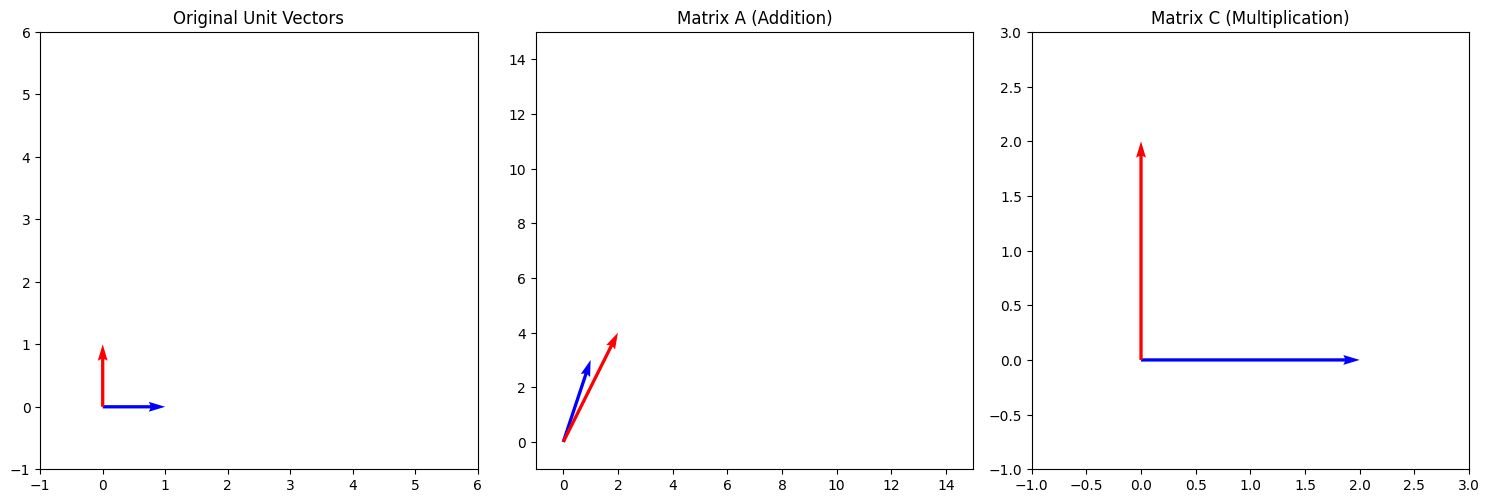

In [3]:
# Define the matrices
A = np.array([[1, 2],
              [3, 4]])

B = np.array([[5, 6],
              [7, 8]])

C = np.array([[2, 0],
              [0, 2]])

# Define the unit vectors
unit_vector_x = np.array([1, 0])
unit_vector_y = np.array([0, 1])

# Define the origin
origin = np.array([0, 0])

# Function to plot vectors
def plot_vectors(vectors, colors, labels):
    for i in range(len(vectors)):
        plt.quiver(*origin, vectors[i][0], vectors[i][1], color=colors[i], scale=1, scale_units='xy', angles='xy', label=labels[i])

# Initialize the figure
plt.figure(figsize=(15, 5))

# Plot original unit vectors
plt.subplot(1, 3, 1)
plt.title('Original Unit Vectors')
plot_vectors([unit_vector_x, unit_vector_y], ['b', 'r'], ['X-axis', 'Y-axis'])
plt.xlim(-1, 6)
plt.ylim(-1, 6)
plt.gca().set_aspect('equal', adjustable='box')

# Apply matrix A (Addition)
transformed_x_A = A.dot(unit_vector_x)
transformed_y_A = A.dot(unit_vector_y)

plt.subplot(1, 3, 2)
plt.title('Matrix A (Addition)')
plot_vectors([transformed_x_A, transformed_y_A], ['b', 'r'], ['X-axis', 'Y-axis'])
plt.xlim(-1, 15)
plt.ylim(-1, 15)
plt.gca().set_aspect('equal', adjustable='box')

# Apply matrix C (Multiplication)
transformed_x_C = C.dot(unit_vector_x)
transformed_y_C = C.dot(unit_vector_y)

plt.subplot(1, 3, 3)
plt.title('Matrix C (Multiplication)')
plot_vectors([transformed_x_C, transformed_y_C], ['b', 'r'], ['X-axis', 'Y-axis'])
plt.xlim(-1, 3)
plt.ylim(-1, 3)
plt.gca().set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()


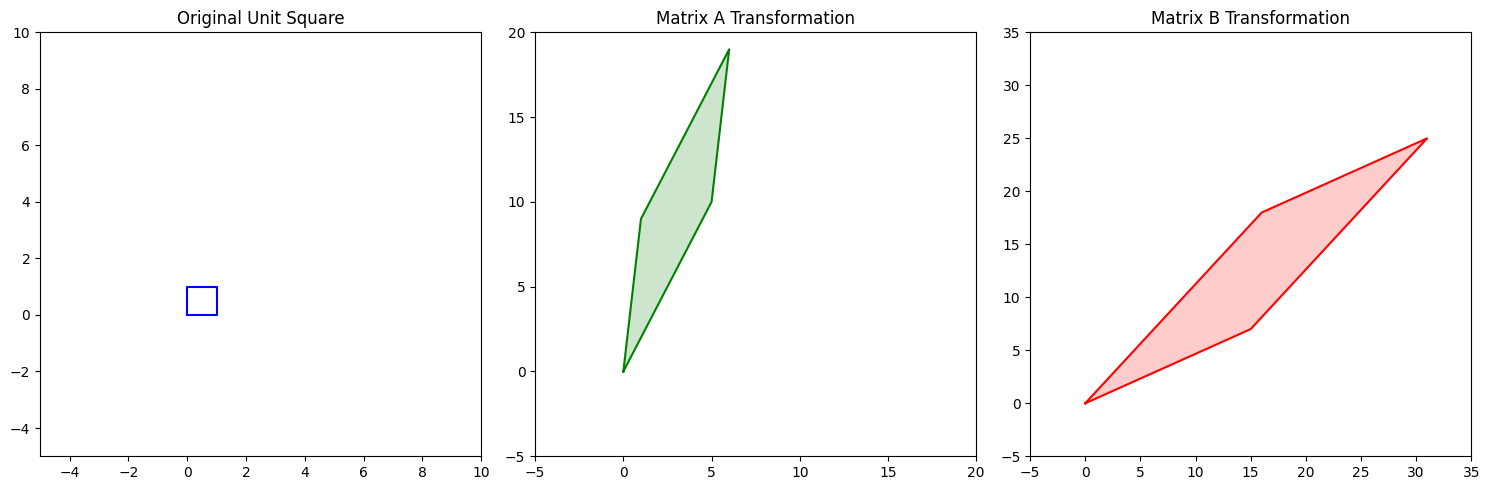

In [50]:
import numpy as np
import matplotlib.pyplot as plt

# Define the matrices
A = np.array([[1, 5],
              [9, 10]])

B = np.array([[15, 16],
              [7, 18]])

C = np.array([[12, 10],
              [10, 12]])

# Define the unit square
unit_square = np.array([[0, 0, 1, 1, 0],
                        [0, 1, 1, 0, 0]])

identity_matrix = np.array([[1, 0],
                            [0, 1,]])

# Apply matrices to the unit square
transformed_square_A = A.dot(unit_square)
transformed_square_B = B.dot(unit_square)
transformed_square_C = C.dot(unit_square)

# Initialize the figure
plt.figure(figsize=(15, 5))

# Plot the original unit square
plt.subplot(1, 3, 1)
plt.title('Original Unit Square')
plt.plot(unit_square[0], unit_square[1], 'b-')
plt.fill(unit_square[0], unit_square[1], 'b', alpha=0.2)
plt.xlim(-5, 10)
plt.ylim(-5, 10)

# Plot the transformed unit square for matrix A
plt.subplot(1, 3, 2)
plt.title('Matrix A Transformation')
plt.plot(transformed_square_A[0], transformed_square_A[1], 'g-')
plt.fill(transformed_square_A[0], transformed_square_A[1], 'g', alpha=0.2)
plt.xlim(-5, 20)
plt.ylim(-5, 20)

# Plot the transformed unit square for matrix B
plt.subplot(1, 3, 3)
plt.title('Matrix B Transformation')
plt.plot(transformed_square_B[0], transformed_square_B[1], 'r-')
plt.fill(transformed_square_B[0], transformed_square_B[1], 'r', alpha=0.2)
plt.xlim(-5, 35)
plt.ylim(-5, 35)

plt.tight_layout()
plt.show()


In [61]:
%matplotlib notebook
from IPython.display import HTML

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Define the unit square
unit_square = np.array([[0, 0, 3, 3, 0],
                        [0, 3, 3, 0, 0]])

# Define the transformations
transformations = [
    #{"matrix": np.array([[1, 2],
    #                     [3, 4]]), "label": "Addition"},
    #{"matrix": np.array([[-1, -2],
    #                     [-3, -4]]), "label": "Subtraction"},
    {"matrix": np.array([[3, 6],
                         [5, 1]]), "label": "Multiplication"},
    {"matrix": np.array([[0, -1],
                         [1, 0]]), "label": "Rotation"},
]

# Initialize the figure
fig, ax = plt.subplots(figsize=(7, 5))
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_aspect('equal', 'box')

# Define an update function
def update(frame):
    ax.clear()
    ax.set_xlim(-5, 40)
    ax.set_ylim(-5, 40)
    ax.set_aspect('equal', 'box')
    
    # Apply the transformation
    transformed_square = np.dot(transformations[frame]["matrix"], unit_square)
    
    # Plot the original and transformed unit squares
    ax.plot(unit_square[0], unit_square[1], 'b-')
    ax.fill(unit_square[0], unit_square[1], 'b', alpha=0.2)
    
    ax.plot(transformed_square[0], transformed_square[1], 'g-')
    ax.fill(transformed_square[0], transformed_square[1], 'g', alpha=0.2)
    
    plt.title(transformations[frame]["label"])

# Create the animation
animation = FuncAnimation(fig, update, frames=len(transformations), repeat=False)
plt.show()
HTML(animation.to_jshtml())

<IPython.core.display.Javascript object>

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Define the unit square
unit_square = np.array([[0, 0, 1, 1, 0],
                        [0, 1, 1, 0, 0]])

# Define the transformations
transformations = [
    {"matrix": np.array([[0, 3, 2, 4, 0],
                         [0, 3, 2, 4, 0]]), "label": "Addition"},
    {"matrix": np.array([[0, 6, 3, 5, 0],
                         [0, 6, 3, 5, 0]]), "label": "Subtraction"},
]

# Initialize the figure
fig, ax = plt.subplots(figsize=(7, 5))
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_aspect('equal', 'box')

# Define an update function
def update(frame):
    ax.clear()
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.set_aspect('equal', 'box')
    
    # Apply the transformation
    transformed_square = unit_square + transformations[frame]["matrix"]
    
    # Plot the original and transformed unit squares
    ax.plot(unit_square[0], unit_square[1], 'b-')
    ax.fill(unit_square[0], unit_square[1], 'b', alpha=0.2)
    
    ax.plot(transformed_square[0], transformed_square[1], 'g-')
    ax.fill(transformed_square[0], transformed_square[1], 'g', alpha=0.2)
    
    plt.title(transformations[frame]["label"])

# Create the animation
animation = FuncAnimation(fig, update, frames=len(transformations), repeat=False)
plt.show()

HTML(animation.to_jshtml())

<IPython.core.display.Javascript object>

In [80]:
help(np.meshgrid)

Help on _ArrayFunctionDispatcher in module numpy:

meshgrid(*xi, copy=True, sparse=False, indexing='xy')
    Return a list of coordinate matrices from coordinate vectors.
    
    Make N-D coordinate arrays for vectorized evaluations of
    N-D scalar/vector fields over N-D grids, given
    one-dimensional coordinate arrays x1, x2,..., xn.
    
    .. versionchanged:: 1.9
       1-D and 0-D cases are allowed.
    
    Parameters
    ----------
    x1, x2,..., xn : array_like
        1-D arrays representing the coordinates of a grid.
    indexing : {'xy', 'ij'}, optional
        Cartesian ('xy', default) or matrix ('ij') indexing of output.
        See Notes for more details.
    
        .. versionadded:: 1.7.0
    sparse : bool, optional
        If True the shape of the returned coordinate array for dimension *i*
        is reduced from ``(N1, ..., Ni, ... Nn)`` to
        ``(1, ..., 1, Ni, 1, ..., 1)``.  These sparse coordinate grids are
        intended to be use with :ref:`basics.b

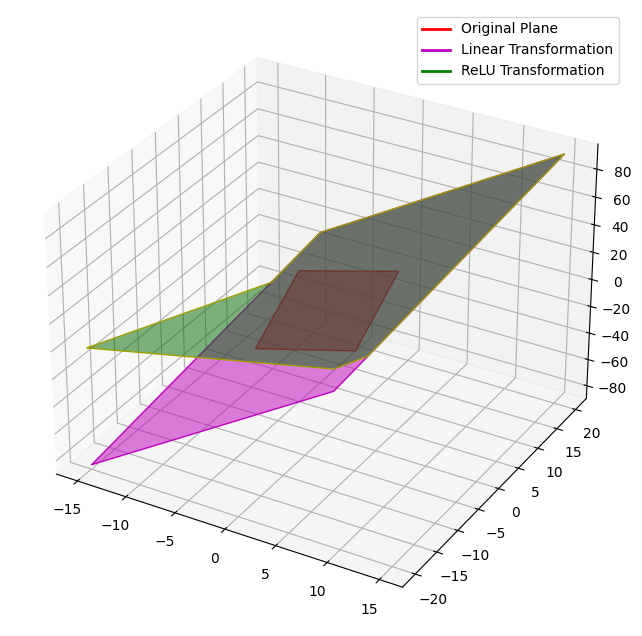

In [74]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D

# Define a plane in 3D space
x = np.linspace(-5, 5, 100) # (100,100)
y = np.linspace(-5, 5, 100) # (100,100)
x, y = np.meshgrid(x, y)
z = 2*x + 3*y + 4 # (100,100)

# Initialize the figure
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the original plane
ax.plot_surface(x, y, z, alpha=0.5, rstride=100, cstride=100, color='r', edgecolors='r', label='Original Plane')

# Define a linear transformation matrix
linear_transformation = np.array([[2, 1],
                                  [1, 3]])

# Apply linear transformation
x_transformed = linear_transformation[0, 0] * x + linear_transformation[0, 1] * y
y_transformed = linear_transformation[1, 0] * x + linear_transformation[1, 1] * y
z_transformed = 2*x_transformed + 3*y_transformed + 4

# Plot the transformed plane
ax.plot_surface(x_transformed, y_transformed, z_transformed, alpha=0.5, rstride=100, cstride=100, color='m', edgecolors='m', label='Linear Transformation')

# Define a ReLU (Rectified Linear Unit) non-linear transformation
def relu(x):
    return np.maximum(0, x)

# Apply ReLU transformation
z_relu = relu(z_transformed)

# Plot the ReLU transformed plane
ax.plot_surface(x_transformed, y_transformed, z_relu, alpha=0.5, rstride=100, cstride=100, color='g', edgecolors='y', label='ReLU Transformation')

# Add a legend
# Create a legend manually
legend_elements = [
    Line2D([0], [0], color='r', lw=2, label='Original Plane'),
    Line2D([0], [0], color='m', lw=2, label='Linear Transformation'),
    Line2D([0], [0], color='g', lw=2, label='ReLU Transformation')
]

# Add a legend
ax.legend(handles=legend_elements)

# Show the plot
plt.show()

In [66]:
from mpl_toolkits.mplot3d import Axes3D

# Define a plane in 3D space
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
x, y = np.meshgrid(x, y)
z = 2*x + 3*y + 4

# Initialize the figure
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Define a linear transformation matrix
linear_transformation = np.array([[2, 1],
                                  [1, 3]])

# Define a ReLU (Rectified Linear Unit) non-linear transformation
def relu(x):
    return np.maximum(0, x)

# Define update function for animation
def update(frame):
    ax.clear()
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.set_zlim(0, 40)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    z_transformed = z
    if frame == 0:
        z_transformed = z
        label = 'Original Plane'
    elif frame == 1:
        x_transformed = linear_transformation[0, 0] * x + linear_transformation[0, 1] * y
        y_transformed = linear_transformation[1, 0] * x + linear_transformation[1, 1] * y
        z_transformed = 2*x_transformed + 3*y_transformed + 4
        label = 'Linear Transformation'
    else:
        z_transformed = relu(z_transformed)
        label = 'ReLU Transformation'
    
    ax.plot_surface(x, y, z_transformed, alpha=0.5, rstride=100, cstride=100, edgecolors='k')
    plt.title(label)

# Create the animation
animation = FuncAnimation(fig, update, frames=3, repeat=False, interval=3000)
plt.show()

HTML(animation.to_jshtml())

<IPython.core.display.Javascript object>